Signal decomposition with Deep Learning  
Author: Javier Gamero Muñoz

# General libraries

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from decompose import quality

# Load data

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
PATH

'/Users/javigamero/MyMac/DS_Master/TFM'

In [3]:
idx_path = os.path.join(PATH, 'data_preproc/LightSignal_total.csv')
idxs = pd.read_csv(idx_path, sep=';', header=None)
idxs = np.array(idxs.iloc[:,0]).reshape(-1)
idxs

array(['0_1', '0_4', '0_6', ..., '399_42', '399_43', '399_48'],
      dtype=object)

In [4]:
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')
t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t.set_index(0, inplace=True)

In [5]:
t0 = 150 # (ns), moment to start considering the slow component, EXPERIMENTAL
t_idx = np.where(t>t0)[1] 

In [6]:
t = np.array(t.iloc[0, t_idx]).reshape(-1) #1D array from t0 and on
t.shape

(985,)

In [7]:
e_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_e.csv')
e_signals = pd.read_csv(e_GT_path, sep=';', header=None)
e_signals.set_index(0, inplace=True)
e_signals = e_signals.loc[idxs, :] # take only those with the electron

mu_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_mu.csv')
mu_signals = pd.read_csv(mu_GT_path, sep=';', header=None)
mu_signals.set_index(0, inplace=True)
mu_signals = mu_signals.loc[idxs, :] # take only those with the electron

# total signal: 
signals = mu_signals + e_signals

Functions to create fasts plots:

In [8]:
def plotSignals(t, v, labels, xlabel='Time, t (ns)', ylabel='# photons', sep=False,
                figsize=(5,5)): 
    if len(v)!=len(labels): 
        print('Wrong number of labels')
        return
    
    # in separate plots
    if sep: 
        fig, axs = plt.subplots(1,len(v), figsize=figsize)
        for i in range(len(v)): 
            axs[i].plot(t, v[i], label=labels[i])
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel(ylabel) 
            axs[i].legend(loc='best')
            
        plt.tight_layout()
        plt.show()

        return
    
    # all in one figure and plot
    else: 
        plt.figure(figsize=figsize)
        for i in range(len(v)): 
            plt.plot(t, v[i], label=labels[i], alpha=0.75)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc='best')
        plt.show()
        
        return
    
# this function will plot the loss results of NN training. It should be used 
# to check if the NN is oferfitting 
def NN_trainPlot(history): 
    fig, ax = plt.subplots(1,1)

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    ax.plot(loss, 'r.', label='Train')
    ax.plot(val_loss, 'b-', label='Validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc='best')

    plt.show()

0_9


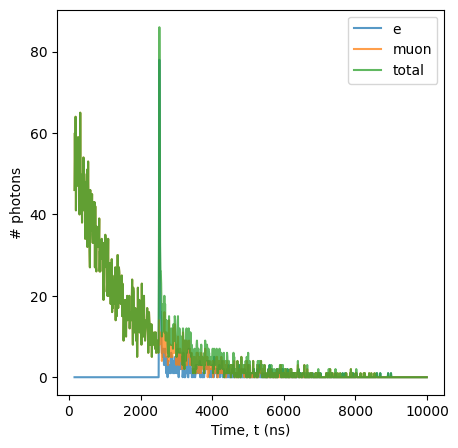

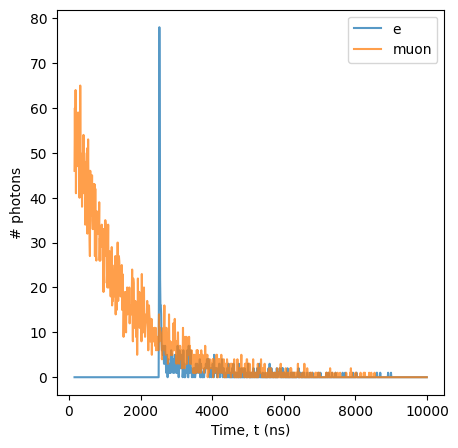

In [9]:
i = 4
print(idxs[i])
e_signal = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1)
mu_signal = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1)
signal = np.array(signals.loc[idxs[i], t_idx]).reshape(-1)

v = [e_signal, mu_signal, signal]
plotSignals(t, v, ['e', 'muon', 'total'])

v = [e_signal, mu_signal]
plotSignals(t, v, ['e', 'muon'])

# Deep learning models

The first thing to know is how we should pass the data to a neural network and 
how to build its output layer. 

## Inputs and outputs

###  Using one time serie

For instance, let's imagine we have a neural network that only receives one 
time serie for the decomposition.  
In this case, the input dimension of the neural network is one since it only 
receives one array. Also, it only have one neural network to predict another 
array

In [12]:
from keras import Sequential
from keras.models import Model
from keras.layers import LSTM, Dense

i = 4
a = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1,1)
b = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1,1)
total = np.array(signals.loc[idxs[i], t_idx]).reshape(-1,1)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation = 'sigmoid', input_dim=1))
model.add(Dense(1, activation='linear'))

In [13]:
X = np.array(signals.loc[idxs[i], t_idx]).reshape(-1,1)
a = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1,1)
b = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1,1)

In [14]:
np.shape(X)

(985, 1)

Epoch 1/100
28/28 [==============================] - 1s 6ms/step - loss: 13.9372 - val_loss: 0.0174
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 13.1349 - val_loss: 0.1555
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 12.8226 - val_loss: 0.2325
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 12.7206 - val_loss: 0.2565
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 12.6679 - val_loss: 0.2184
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 12.6080 - val_loss: 0.1727
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5879 - val_loss: 0.1385
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5587 - val_loss: 0.1093
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5505 - val_loss: 0.0948
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5370 - val_loss: 0.0673

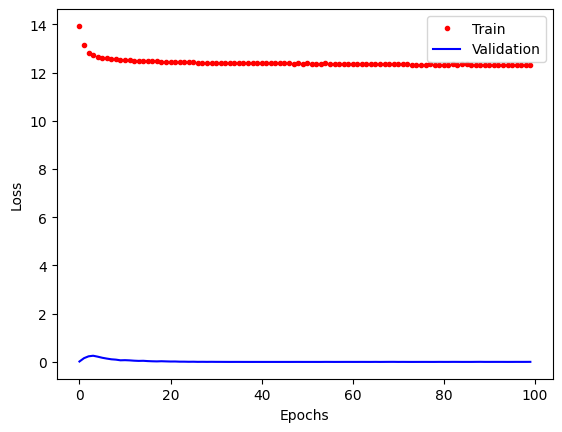

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X, a, batch_size=32, epochs=100, 
                    validation_split=0.1)

NN_trainPlot(history)

Obviously, the model is too simple to achieve a good result, in fact it is 
overfitting. By the moment, we are just learning what and how to give data to 
the model. 

31/31 [==============================] - 0s 587us/step


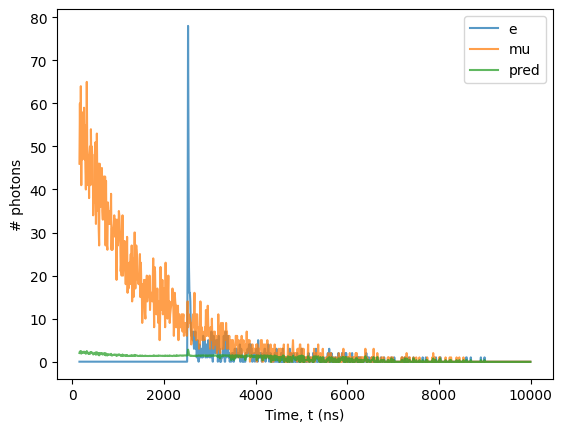

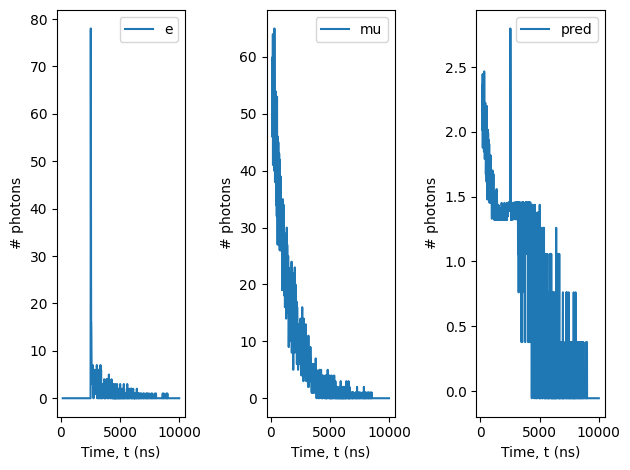

In [17]:
pred = model.predict(X)

v = [a, b, np.array(pred).reshape(-1,1)]
plotSignals(t, v, ['e', 'mu', 'pred'])
plotSignals(t, v, ['e', 'mu', 'pred'], sep=True)

Although it seems to predict where the electron is, we go a step further.

### All time series

Using one time serie does not generalize a model as much as we would want, and 
we can configure a NN to take all the data to train.  
That is exactly our next step.

We generate the training and test datasets:

In [10]:
from sklearn.model_selection import train_test_split
X = np.array(signals.iloc[:, t_idx].values) 
y = np.array(e_signals.iloc[:, t_idx].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

print(X_train.shape)
print(y_train.shape)

(6527, 985)
(6527, 985)


Due to the usage of LSTM layers, we must configure the shape of the inputs.  
Following the **keras** guide, the input shape of the train dataset must be: 
$$(number\_of\_samples,\ number\_of\_timesteps,\ number\_of\_features).$$

In this moment only have one feature, so we only add a new axis to `X`:

In [11]:
X_train = X_train[:, :, np.newaxis]

timesteps = int(X_train.shape[1])
features = int(X_train.shape[2])
input_shape = (timesteps,features)

print(input_shape)

(985, 1)


The only thing missing is the **output layer configuration**. We will give a dataset 
X_test to the NN after the training and its output must be one time serie for 
each sample with the same timesteps.  

To achieve it, we will configure the NN with LSTM layers having the parameter 
`return_sequences=True`. This way, the LSTM output is the evaluation at each 
timestep.  
Also, we are configuring one output `Dense` layer with one neuron and linear 
function activation to give the prediction.

Epoch 1/2
143/143 [==============================] - 27s 189ms/step - loss: 2.7269 - val_loss: 2.6790
Epoch 2/2
143/143 [==============================] - 27s 188ms/step - loss: 2.6635 - val_loss: 2.6375


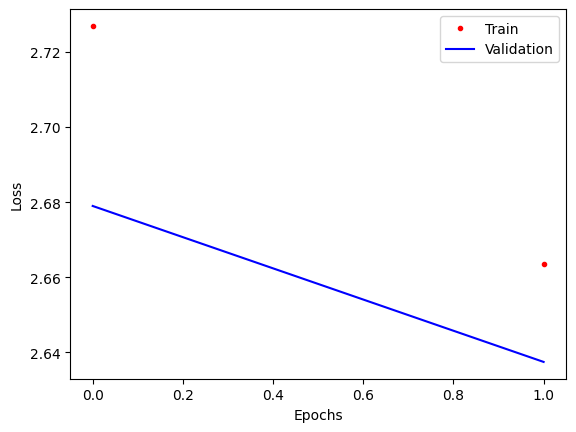

In [15]:
from keras import Sequential
from keras.layers import LSTM, Dense
from keras.utils import set_random_seed

set_random_seed(2023)
model = Sequential()
model.add(LSTM(units=64, activation = 'sigmoid', return_sequences=True,
               input_shape=input_shape))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=2, 
          validation_split=0.3)

NN_trainPlot(history)

In [16]:
y_pred = model.predict(X_test[:,:, np.newaxis]) 

88/88 [==============================] - 4s 44ms/step


In [17]:
np.shape(y_pred)

(2798, 985, 1)

As we can see, the output prediction has the shape we need, 
$$(number\_of\_test\_samples,\ number\_of\_timesteps, 1).$$

Let's check a random prediction:

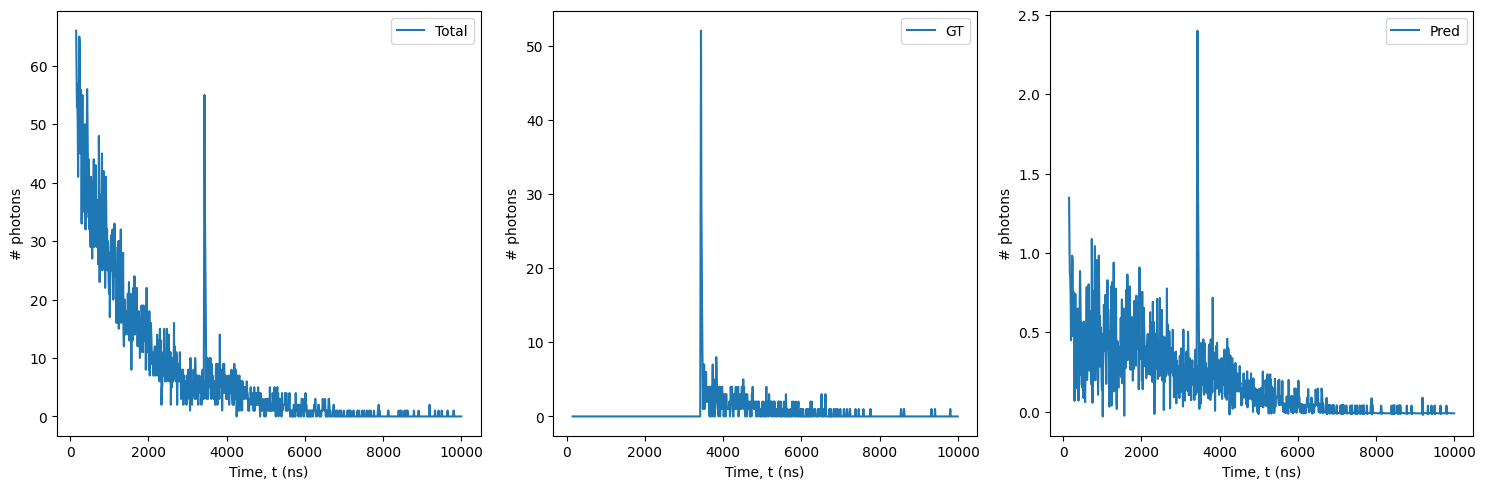

In [18]:
y_pred = y_pred[:,:,0]
i=5
v = [X_test[i,:], y_test[i,:], np.array(y_pred[i,:])]
plotSignals(t, v, ['Total', 'GT', 'Pred'], sep='True', figsize=(15,5))

As we can see, this model is too little to reproduce the results, we would need 
a bigger model to improve the signal decomposition.  
**However, we have achieved what we wanted, now, we know how to configure a NN to 
receive our data and produce results.**

## Models

It's time to create bigger models and to use the art state to solve this 
problem.

Function to test a model: 

In [10]:
def testModel(model, history, X_test, y_test):

    NN_trainPlot(history)

    y_pred = model.predict(X_test) 
    y_pred = y_pred[:,:,0] # adjust to (n_samples, n_timesteps)

    i=5
    v = [X_test[i,:,0], y_test[i,:], np.array(y_pred[i,:])]
    plotSignals(t, v, ['Total', 'GT', 'Pred'], sep='True', figsize=(15,5))

    e_found = 0
    for GT, pred in zip(y_test, y_pred): 
        q = quality(t, GT, pred)
        if q.isElectronExctracted(): e_found+=1

    print('Ratio e total found: {0}%'.format(e_found / y_test.shape[0] * 100))

### Model 1: one LSTM (bidirectional) hidden layer

We are recreating in each model the train and test folders in order to be able 
of training models separately.

In [11]:
from sklearn.model_selection import train_test_split
X = np.array(signals.iloc[:, t_idx].values) 
y = np.array(e_signals.iloc[:, t_idx].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

X_train = X_train[:, :, np.newaxis].astype('float64')
y_train = y_train.astype('float64')

X_test = X_test[:,:, np.newaxis].astype('float64')
y_test = y_test.astype('float64')

In [12]:
timesteps = int(X_train.shape[1])
features = int(X_train.shape[2])
input_shape = (timesteps,features)

print(input_shape)

(985, 1)


First, we will use a simple bidirectional layer to see if its behaviour:

In [13]:
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.utils import set_random_seed

def model_SimpleBidirectional(n_hidden_layers=1, n_neurons=[16], 
                              activation=['tanh'], timesteps=985, features=1, 
                              seed=2023):

    set_random_seed(seed)
    
    init = True
    input_shape=(timesteps, features)

    model = Sequential()
    for i in range(n_hidden_layers): 
        if init: 
            # also adds the input layer
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True,
                                         input_shape = input_shape
                                         ))) 
            init=False
            
        else: 
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True)))
    
    model.add(Dense(1, activation='linear')) # output layer
    
    return model

Epoch 1/10
143/143 [==============================] - 36s 245ms/step - loss: 2.7117 - val_loss: 2.6625
Epoch 2/10
143/143 [==============================] - 44s 311ms/step - loss: 2.6359 - val_loss: 2.6052
Epoch 3/10
143/143 [==============================] - 45s 315ms/step - loss: 2.5791 - val_loss: 2.5457
Epoch 4/10
143/143 [==============================] - 45s 318ms/step - loss: 2.5243 - val_loss: 2.4864
Epoch 5/10
143/143 [==============================] - 47s 326ms/step - loss: 2.4600 - val_loss: 2.4303
Epoch 6/10
143/143 [==============================] - 43s 304ms/step - loss: 2.3859 - val_loss: 2.3303
Epoch 7/10
143/143 [==============================] - 44s 308ms/step - loss: 2.2896 - val_loss: 2.2326
Epoch 8/10
143/143 [==============================] - 45s 313ms/step - loss: 2.1829 - val_loss: 2.1372
Epoch 9/10
143/143 [==============================] - 44s 307ms/step - loss: 2.0718 - val_loss: 2.0264
Epoch 10/10
143/143 [==============================] - 45s 314ms/step - l

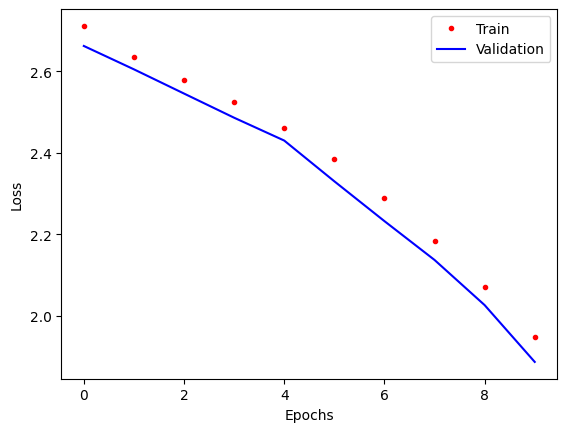

88/88 [==============================] - 5s 61ms/step


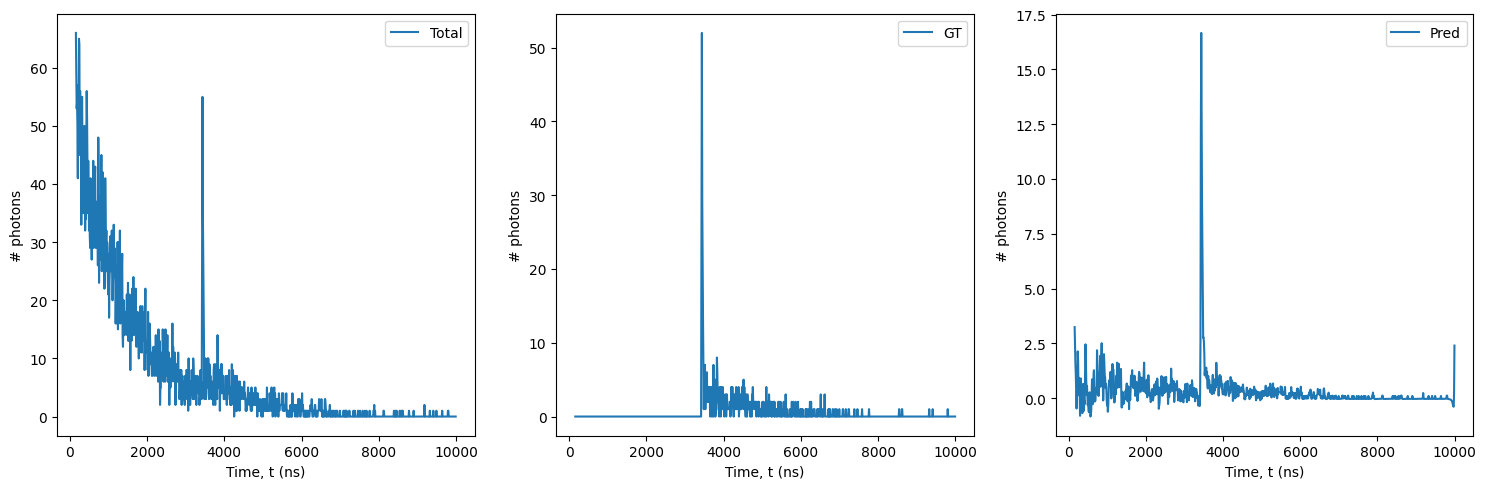

Ratio e total found: 50.964974982130094%


In [14]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['sigmoid'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, X_test, y_test)

Comment results

Epoch 1/10
143/143 [==============================] - 31s 207ms/step - loss: 2.6529 - val_loss: 2.5548
Epoch 2/10
143/143 [==============================] - 29s 202ms/step - loss: 2.4850 - val_loss: 2.4097
Epoch 3/10
143/143 [==============================] - 28s 199ms/step - loss: 2.2897 - val_loss: 2.2564
Epoch 4/10
143/143 [==============================] - 29s 200ms/step - loss: 2.0817 - val_loss: 2.0552
Epoch 5/10
143/143 [==============================] - 29s 206ms/step - loss: 1.9548 - val_loss: 1.8514
Epoch 6/10
143/143 [==============================] - 29s 204ms/step - loss: 1.7232 - val_loss: 1.6429
Epoch 7/10
143/143 [==============================] - 29s 203ms/step - loss: 1.6487 - val_loss: 1.5200
Epoch 8/10
143/143 [==============================] - 29s 203ms/step - loss: 1.4576 - val_loss: 1.9410
Epoch 9/10
143/143 [==============================] - 29s 205ms/step - loss: 1.5473 - val_loss: 1.4335
Epoch 10/10
143/143 [==============================] - 29s 205ms/step - l

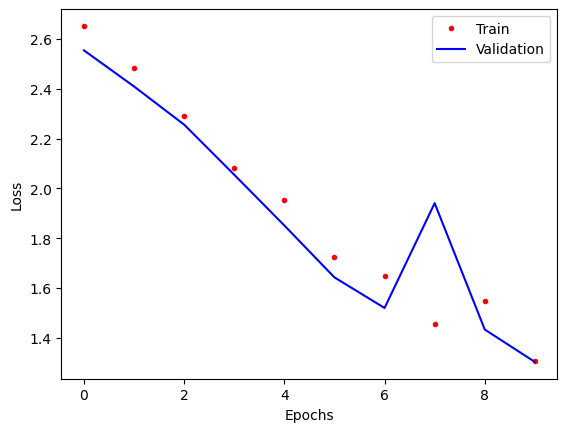

88/88 [==============================] - 4s 45ms/step


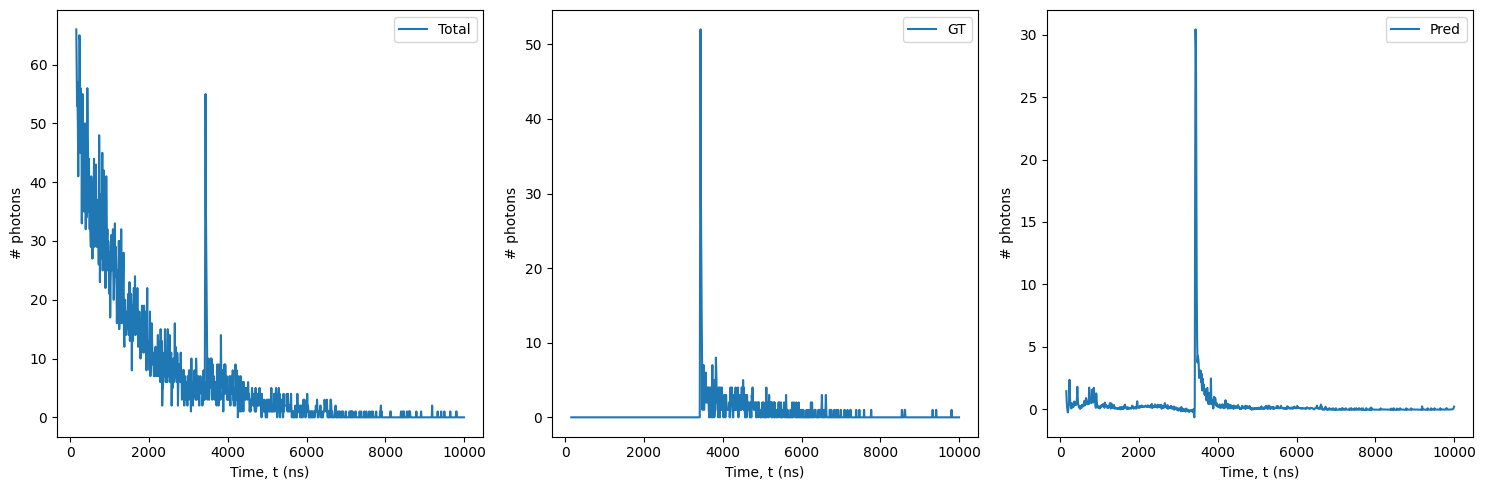

Ratio e total found: 47.140814867762685%


In [15]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, X_test, y_test)

It seems that the activation `tanh` works better. 
Also, looking at the history plot, we can see that the model could achieve a 
better loss. However, we prefer to create another model with more hidden layers. 

Before, we use test optimizer: 

Epoch 1/10
143/143 [==============================] - 30s 201ms/step - loss: 2.6639 - val_loss: 2.6138
Epoch 2/10
143/143 [==============================] - 28s 195ms/step - loss: 2.5285 - val_loss: 2.4322
Epoch 3/10
143/143 [==============================] - 28s 197ms/step - loss: 2.4369 - val_loss: 2.3632
Epoch 4/10
143/143 [==============================] - 29s 206ms/step - loss: 2.2651 - val_loss: 2.3408
Epoch 5/10
143/143 [==============================] - 29s 205ms/step - loss: 2.1446 - val_loss: 2.0824
Epoch 6/10
143/143 [==============================] - 29s 201ms/step - loss: 2.0281 - val_loss: 1.9541
Epoch 7/10
143/143 [==============================] - 29s 202ms/step - loss: 1.8355 - val_loss: 1.7532
Epoch 8/10
143/143 [==============================] - 29s 200ms/step - loss: 1.6811 - val_loss: 1.6229
Epoch 9/10
143/143 [==============================] - 29s 200ms/step - loss: 1.5684 - val_loss: 1.5403
Epoch 10/10
143/143 [==============================] - 29s 200ms/step - l

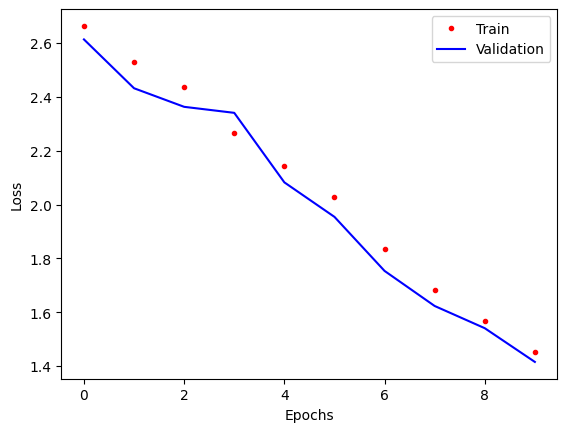

88/88 [==============================] - 4s 45ms/step


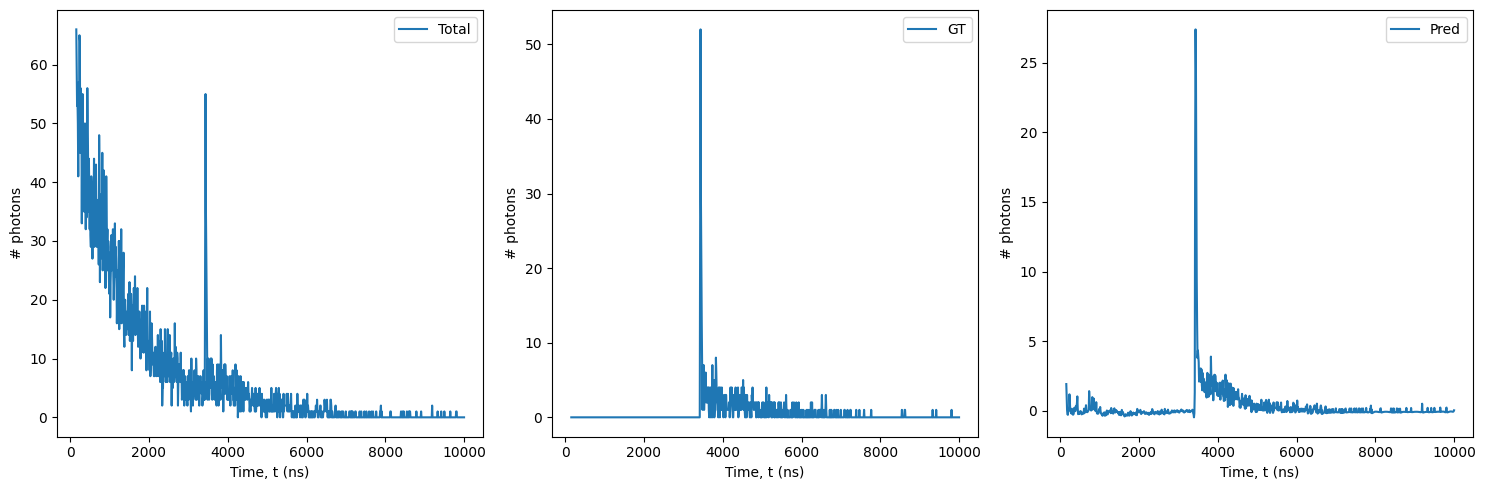

Ratio e total found: 55.28949249463903%


In [16]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, X_test, y_test)

Let's test another optimizer: 

Epoch 1/10
143/143 [==============================] - 31s 206ms/step - loss: 2.7184 - val_loss: 2.7036
Epoch 2/10
143/143 [==============================] - 29s 200ms/step - loss: 2.6907 - val_loss: 2.6726
Epoch 3/10
143/143 [==============================] - 28s 199ms/step - loss: 2.6714 - val_loss: 2.6598
Epoch 4/10
143/143 [==============================] - 28s 198ms/step - loss: 2.6549 - val_loss: 2.6416
Epoch 5/10
143/143 [==============================] - 28s 197ms/step - loss: 2.6362 - val_loss: 2.6405
Epoch 6/10
143/143 [==============================] - 28s 197ms/step - loss: 2.6209 - val_loss: 2.6000
Epoch 7/10
143/143 [==============================] - 27s 190ms/step - loss: 2.6061 - val_loss: 2.5795
Epoch 8/10
143/143 [==============================] - 27s 191ms/step - loss: 2.5884 - val_loss: 2.5982
Epoch 9/10
143/143 [==============================] - 28s 196ms/step - loss: 2.5768 - val_loss: 2.5825
Epoch 10/10
143/143 [==============================] - 27s 191ms/step - l

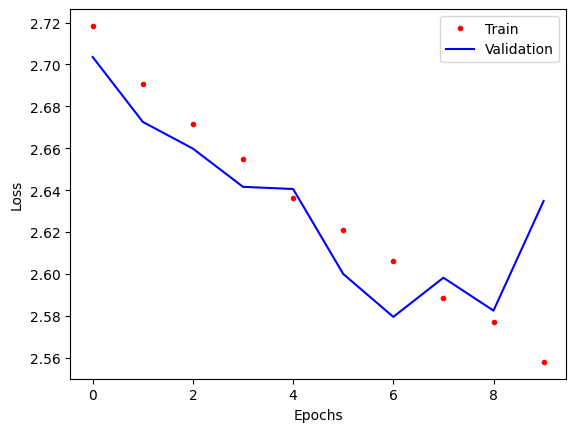

88/88 [==============================] - 4s 44ms/step


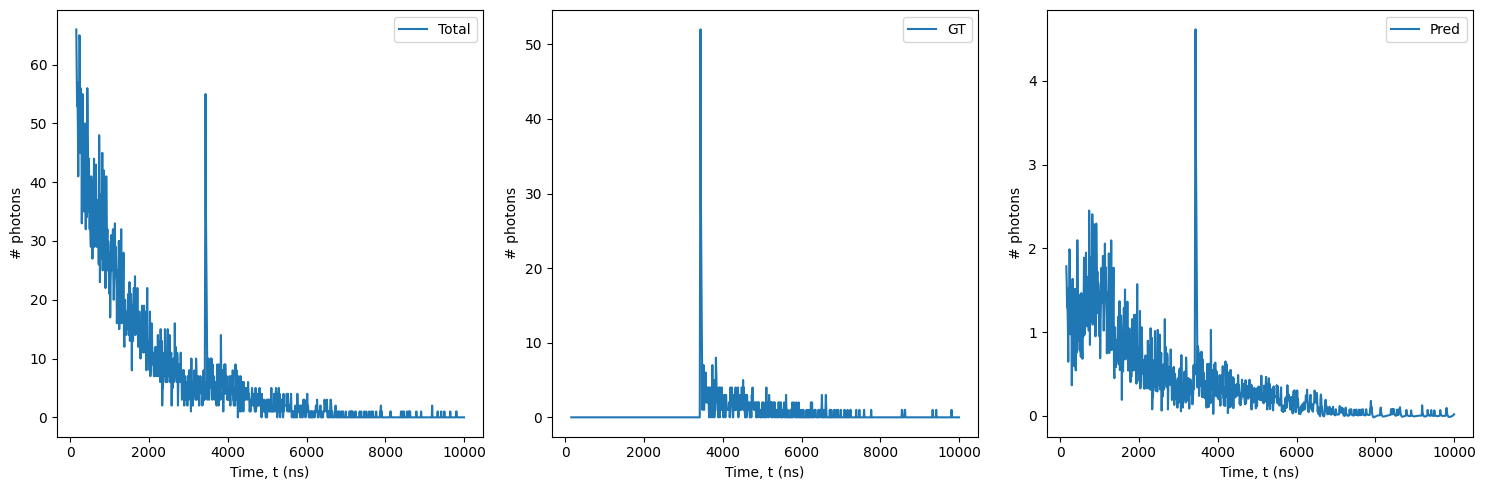

Ratio e total found: 36.09721229449607%


In [17]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='SGD', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, X_test, y_test)

After watching all the results of several executions we create a table to 
compare them: 
|Model        |e found ratio |MSE
|:-----------:|:------------:|---------|
|sigmoid/adam |~51%          |1.89
|tanh/adam    |~47%          |1.30
|tanh/RMSprop |~55%          |1.41
|tanh/SGD     |~36%          |2.63

The best two models are those with the `tanh` function activation and the 
optimize `adam` and `RMSprop`.  
Instead of taking only one of them, we train them again with more epochs. After 
all, the trend pointed out that they could improve more.

In [ ]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=50, 
                    validation_split=0.3)

testModel(model, history, X_test, y_test)

In [ ]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=50, 
                    validation_split=0.3)

testModel(model, history, X_test, y_test)

### Model 2: more hidden layers

Now, we add more hidden layers.

In [11]:
from sklearn.model_selection import train_test_split
X = np.array(signals.iloc[:, t_idx].values) 
y = np.array(e_signals.iloc[:, t_idx].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

X_train = X_train[:, :, np.newaxis].astype('float64')
y_train = y_train.astype('float64')

X_test = X_test[:,:, np.newaxis].astype('float64')
y_test = y_test.astype('float64')

timesteps = int(X_train.shape[1])
features = int(X_train.shape[2])
input_shape = (timesteps,features)

print(input_shape)

(985, 1)


## Using $\mu$ signal as a feature

As we can see from the earlier figures, the NN is capable of extracting the data.  
Now, let's create an equal model that also receives the signal of the muon as a 
feature:

In [18]:
X = np.array(signals.loc[idxs[i], t_idx]).reshape(-1,1)
X_m = np.array([X, b])
X_m.shape
# y = a

(2, 985, 1)

In [19]:
model = Sequential()
model.add(LSTM(units=50, activation = 'sigmoid', input_shape=(985,1)))
model.add(Dense(1, activation='linear'))

Epoch 1/50
1/1 [==============================] - 1s 622ms/step - loss: 8.1316e-08 - val_loss: 0.0022
Epoch 2/50
1/1 [==============================] - 0s 103ms/step - loss: 0.0022 - val_loss: 1.5470e-05
Epoch 3/50
1/1 [==============================] - 0s 101ms/step - loss: 1.5470e-05 - val_loss: 0.0015
Epoch 4/50
1/1 [==============================] - 0s 102ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/50
1/1 [==============================] - 0s 107ms/step - loss: 0.0013 - val_loss: 2.0408e-04
Epoch 6/50
1/1 [==============================] - 0s 104ms/step - loss: 2.0409e-04 - val_loss: 1.1898e-04
Epoch 7/50
1/1 [==============================] - 0s 102ms/step - loss: 1.1898e-04 - val_loss: 7.5396e-04
Epoch 8/50
1/1 [==============================] - 0s 105ms/step - loss: 7.5396e-04 - val_loss: 8.5358e-04
Epoch 9/50
1/1 [==============================] - 0s 101ms/step - loss: 8.5358e-04 - val_loss: 3.6104e-04
Epoch 10/50
1/1 [==============================] - 0s 99ms/step - loss

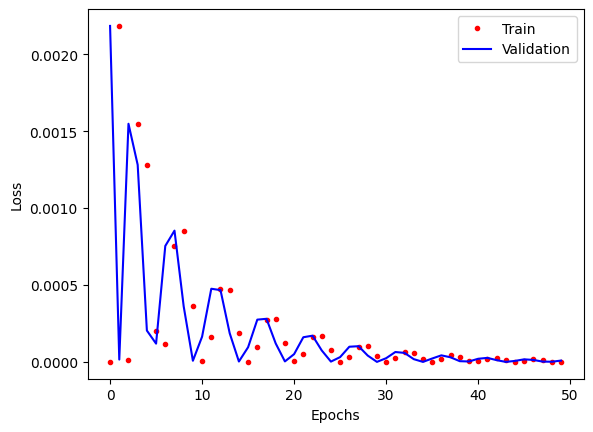

In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_m, a, batch_size=30, epochs=50, 
                    validation_split=0.1)
NN_trainPlot(history)

In this case, this little neural network achieves to minimize the loss in 
validation and not overfitting. This implies that adding the signal of the muon 
as a features is a good option.

31/31 [==============================] - 0s 532us/step


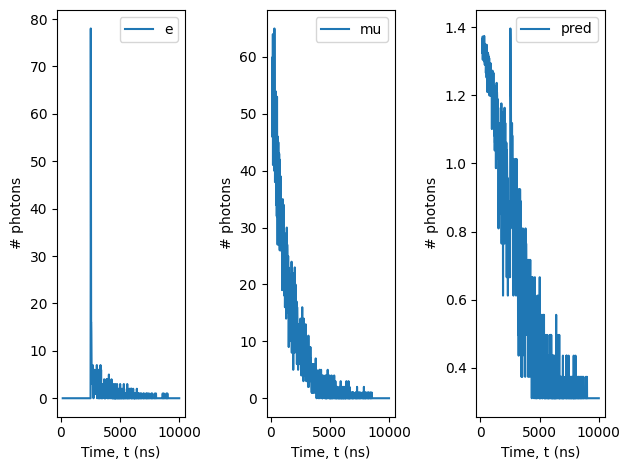

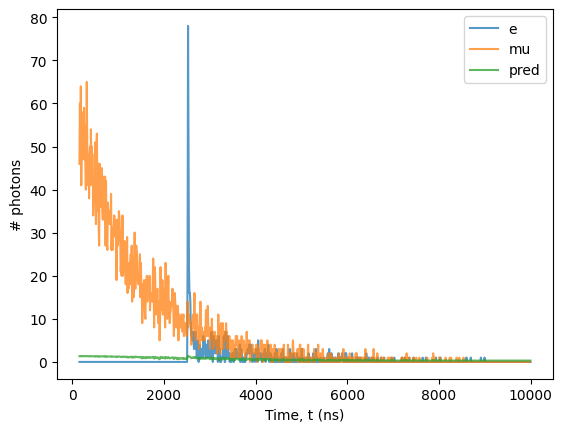

In [26]:
pred = model.predict(X)

v = [a, b, np.array(-pred).reshape(-1,1)]
plotSignals(t, v, ['e', 'mu', 'pred'], sep=True)
plotSignals(t, v, ['e', 'mu', 'pred'], sep=False)

When predicting, we have still the same problem it seems the predicted serie is 
too low although the loss 